
MNIST for Tensorflow-lite
----

This notebook is part of this [post](https://www.stupid-projects.com/machine-learning-on-embedded-part-3) which is part a series of post about using ML and NN in embedded MCUs. The first post of the series is [here](https://www.stupid-projects.com/machine-learning-on-embedded-part-1)

This notebook is just a port of [this](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.1-introduction-to-convnets.ipynb) notebook from Keras to TF.

This notebook is meant to be used to train the MNIST NN and then export the model to TF-Lite for microcontrollers and uploaded to a stm32f746. Later there's a cell in the notebook that you can hand-draw a number on a window and then evaluate the model on both the notebook and the stm32f746 by running the inference.



## 1. Create the model

As it's mentioned before, this is just a port from Keras to TF of [this](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.1-introduction-to-convnets.ipynb) notebook. For the model training we're going to use `convnets`.

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version {}".format(tf.__version__))

/home/jpdz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jpdz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jpdz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jpdz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

TensorFlow version 1.14.0


/home/jpdz/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jpdz/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jpdz/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jpdz/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_

In [3]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()
print(train_labels.shape)
train_labels = tf.keras.utils.to_categorical(train_labels)
print(train_labels.shape)
print("Labels:", len(train_labels[0]))
print(train_images[0].shape)

(60000,)
(60000, 10)
Labels: 10
(28, 28)


#### Convert train and test data
Normally when the dataset is loaded the shape is (x, 28, 28). For convnets you need to reshape the data to (x, 28, 28, y), where `x` is the number of images per set and `y` in this case is the number of colors. Normally, of RGB it should be 3, but since the images are grayscale then it's 1.

In [46]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

test_labels = tf.keras.utils.to_categorical(test_labels)

In [47]:
print("Data type:", type(train_images))
print("Dataset shape:", (train_images.shape))

Data type: <class 'numpy.ndarray'>
Dataset shape: (60000, 28, 28, 1)


In [48]:
print("Labels:", len(train_labels))
print("Possible values:", np.unique(train_labels))


Labels: 60000
Possible values: [0. 1.]


#### Print a digit from the dataset
Now we just print a digit from the dataset in order to see how it looks like.

In [49]:
def display_img(img):
    img = np.array(img, dtype='float')
    pixels = img.reshape((28, 28))
    plt.figure()
    plt.imshow(pixels, cmap='gray')
    plt.colorbar()
    plt.grid(False)
    plt.xlabel("Classification label: {}".format(train_labels[0]))
    plt.show()
    print(train_labels[0])

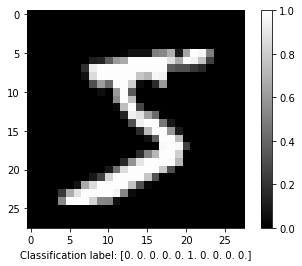

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [50]:
display_img(train_images[0])

## 2. Train the model

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
model.fit(train_images, train_labels, epochs=5, batch_size=2)

Epoch 1/5
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.1446 - acc: 0.9637
Epoch 2/5
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.1490 - acc: 0.9765
Epoch 3/5
60000/60000 [==============================] - 70s 1ms/sample - loss: 0.1859 - acc: 0.9750
Epoch 4/5
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.2158 - acc: 0.9745
Epoch 5/5
60000/60000 [==============================] - 67s 1ms/sample - loss: 0.2151 - acc: 0.9752


In [53]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 91us/sample - loss: 0.1450 - acc: 0.9818
Test accuracy: 0.9818


In [54]:
model.summary()
loss, acc = model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))
print("Restored model, loss: {}".format(loss))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

## 3. Convert the model to tflite

Now we need to export the model and save it in a `h5` file. Then we use the `TFLiteConverter` to convert the model to the flatbuffer tflite format.

Normally, we should use quantization on the model as it's explained [here](https://www.tensorflow.org/lite/microcontrollers/build_convert#quantization), but for some reason in the current version I'm using (1.14) that doesn't work and when the model is loaded on the stm32f746, then I get this error:

```
Only float32, int16, int32, int64, uint8, bool, complex64 supported currently
```

This error comes from the `source/libs/tensorflow/lite/experimental/micro/simple_tensor_allocator.cc` file and the reason is that when the model is converted with `TFLiteConverter`, then the output is set to `kTfLiteInt8`, which means signed integer and that is not yet supported.

In [55]:
model.save('mnist-tflite.h5')

> Note: If you want to add post-quantization during conversion (which doesn't work yet), then you need to uncomment the line in the next code. Finally, the output of the next command is the size of the flatbuffer model in bytes.

In [56]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model_file('mnist-tflite.h5')
tflite_model = converter.convert()

# Save the model to disk
flatbuffer_size = open("mnist.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model_file('mnist-tflite.h5')
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
flatbuffer_size_quantized = open("mnist_quantized.tflite", "wb").write(tflite_model)

#print('The size of the converted flatbuffer is: %d bytes' % flatbuffer_size)
#print('The size of the quantized converted flatbuffer is: %d bytes' % flatbuffer_size_quantized) 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.


In [ ]:
!sudo apt-get -qq install xxd

## 4. Create a header file from the tflite model
Now that you have your tflite flatbuffer you can convert it to a header file
in order to add it to your C++ code you need to run this command in bash in
the `jupyter _notebook` folder.

```sh
xxd -i jupyter_notebook/mnist.tflite > source/src/inc/model_data.h
```

#### Note:
In the `source/src/inc/model_data.h` you need to change this line:
```cpp
unsigned char jupyter_notebook_mnist_tflite[] = {
```
to this:
```cpp
const unsigned char jupyter_notebook_mnist_tflite[] = {
```
Otherwise it won't fit in the RAM and you'll get this error:
```sh
stm32f7-mnist-tflite.elf section `.bss' will not fit in region `RAM'
```

## 5. Load model and interpreter

To evaluate the hand-written digit in the notebook then you need to create an interpreter and then feed the image (or array) in the input. You can create that here and use it later in the document.

In [57]:
interpreter = tf.lite.Interpreter(model_path=tflite_mnist_model)
interpreter.allocate_tensors()

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

NameError: name 'tflite_mnist_model' is not defined